In [1]:
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gzip -d train-images-idx3-ubyte.gz
!gzip -d train-labels-idx1-ubyte.gz
!gzip -d t10k-images-idx3-ubyte.gz
!gzip -d t10k-labels-idx1-ubyte.gz
!pip install pypng

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  20.1M      0 --:--:-- --:--:-- --:--:-- 20.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   256k      0 --:--:-- --:--:-- --:--:--  256k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  4835k      0 --:--:-- --:--:-- --:--:-- 4821k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  44097      0 --:--:-- --:--:-- --:--:-- 44097
     |████████████████████████████████| 48 kB 2.2 MB

In [2]:
import os
import struct
import sys
from array import array
from os import path
import png

def read(dataset = "training", path = "."):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array("B", fimg.read())
    fimg.close()

    return lbl, img, size, rows, cols

def write_dataset(labels, data, size, rows, cols, output_dir):
    # create output directories
    output_dirs = [
        path.join(output_dir, str(i))
        for i in range(10)
    ]
    for dir in output_dirs:
        if not path.exists(dir):
            os.makedirs(dir)

    # write data
    for (i, label) in enumerate(labels):
        output_filename = path.join(output_dirs[label], str(i) + ".png")
        print("writing " + output_filename)
        with open(output_filename, "wb") as h:
            w = png.Writer(cols, rows, greyscale=True)
            data_i = [
                data[ (i*rows*cols + j*cols) : (i*rows*cols + (j+1)*cols) ]
                for j in range(rows)
            ]
            w.write(h, data_i)

input_path = '.'
output_path = './mnist'

for dataset in ["training", "testing"]:
    labels, data, size, rows, cols = read(dataset, input_path)
    write_dataset(labels, data, size, rows, cols,
                  path.join(output_path, dataset))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
writing ./mnist/testing/3/5000.png
writing ./mnist/testing/9/5001.png
writing ./mnist/testing/9/5002.png
writing ./mnist/testing/8/5003.png
writing ./mnist/testing/4/5004.png
writing ./mnist/testing/1/5005.png
writing ./mnist/testing/0/5006.png
writing ./mnist/testing/6/5007.png
writing ./mnist/testing/0/5008.png
writing ./mnist/testing/9/5009.png
writing ./mnist/testing/6/5010.png
writing ./mnist/testing/8/5011.png
writing ./mnist/testing/6/5012.png
writing ./mnist/testing/1/5013.png
writing ./mnist/testing/1/5014.png
writing ./mnist/testing/9/5015.png
writing ./mnist/testing/8/5016.png
writing ./mnist/testing/9/5017.png
writing ./mnist/testing/2/5018.png
writing ./mnist/testing/3/5019.png
writing ./mnist/testing/5/5020.png
writing ./mnist/testing/5/5021.png
writing ./mnist/testing/9/5022.png
writing ./mnist/testing/4/5023.png
writing ./mnist/testing/2/5024.png
writing ./mnist/testing/1/5025.png
writing ./mnist/testing/9/5026.png
writing ./mnist/tes

In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [4]:
class MNISTDataset(torch.utils.data.Dataset):
  def __init__(self, db_dir):
    self.moduleToTensor = torchvision.transforms.ToTensor()
    self.lstImgDir = []
    self.lstLabel = []
    for intClass in range(10):
      for file in os.listdir(db_dir+'/'+str(intClass)):
          if file.endswith(".png"):
              self.lstImgDir.append(db_dir+'/'+str(intClass)+'/'+file)
              self.lstLabel.append(intClass)

  def __len__(self):
    return len(self.lstImgDir)

  def __getitem__(self, intIdx):
    pilImg = Image.open(self.lstImgDir[intIdx])
    tenImg = self.moduleToTensor(pilImg)

    intLabel = self.lstLabel[intIdx]
    tenOneHot = torch.zeros(10)
    tenOneHot[intLabel] = 1
    return tenImg, tenOneHot.type(torch.LongTensor)


In [5]:
objTrainDataset = MNISTDataset('./mnist/training')
objTestDataset = MNISTDataset('./mnist/testing')

In [29]:
class Net(torch.nn.Module):
  def __init__(self, activation='sigmoid', initialize='uniform'):
    super(Net, self).__init__()
    self.fc1 = torch.nn.Linear(784,200)
    self.fc2 = torch.nn.Linear(200,100)
    self.fc3 = torch.nn.Linear(100,50)
    self.fc4 = torch.nn.Linear(50,10)

    if initialize == 'uniform':
      torch.nn.init.uniform_(self.fc1.weight)
      torch.nn.init.uniform_(self.fc2.weight)
      torch.nn.init.uniform_(self.fc3.weight)
      torch.nn.init.uniform_(self.fc4.weight)
    elif initialize == 'xavier':
      torch.nn.init.xavier_normal_(self.fc1.weight)
      torch.nn.init.xavier_normal_(self.fc2.weight)
      torch.nn.init.xavier_normal_(self.fc3.weight)
      torch.nn.init.xavier_normal_(self.fc4.weight)
    elif initialize == 'he':
      torch.nn.init.kaiming_normal_(self.fc1.weight)
      torch.nn.init.kaiming_normal_(self.fc2.weight)
      torch.nn.init.kaiming_normal_(self.fc3.weight)
      torch.nn.init.kaiming_normal_(self.fc4.weight)

    if activation == 'sigmoid':
      self.activation = torch.nn.Sigmoid()
    elif activation == 'relu':
      self.activation = torch.nn.ReLU()

    self.softmax = torch.nn.Softmax(dim=1)
    
  def forward(self, x):
    x0 = x.view(-1, 784)
    x1 = self.fc1(x0)
    x2 = self.activation(x1)
    x3 = self.fc2(x2)
    x4 = self.activation(x3)
    x5 = self.fc3(x4)
    x6 = self.activation(x5)
    x7 = self.fc4(x6)
    return self.softmax(x7)

In [32]:
moduleNet = Net(activation='sigmoid', initialize='uniform').cuda()

intLR = 0.05
intMaxEpoch = 1
intBatchsize = 128

objOptim = torch.optim.SGD(moduleNet.parameters(), lr=intLR)

objTrainLoader = torch.utils.data.DataLoader(dataset=objTrainDataset, batch_size=intBatchsize, shuffle=True, num_workers=0)
objTestLoader = torch.utils.data.DataLoader(dataset=objTestDataset, batch_size=1, shuffle=False, num_workers=0)

intMaxStep = objTrainLoader.__len__()

Train Epoch: [0/1]         Step: [0/469]         train loss: 2.3930902481079102  
Train Epoch: [0/1]         Step: [100/469]       train loss: 0.5967060923576355  
Train Epoch: [0/1]         Step: [200/469]       train loss: 0.3387930691242218  
Train Epoch: [0/1]         Step: [300/469]       train loss: 0.3736903369426727  
Train Epoch: [0/1]         Step: [400/469]       train loss: 0.3498384058475494  
Accuracy: 91.73


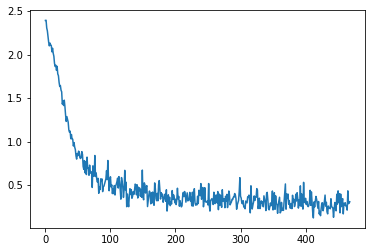

In [31]:
lstLoss = []
moduleNet.train()
for intCurrentEpoch in range(intMaxEpoch):
  for intBatchIdx, (tenImg, tenLabel) in enumerate(objTrainLoader):
    tenImg = tenImg.cuda()
    tenLabel = tenLabel.cuda()
    objOptim.zero_grad()
    tenOutput = moduleNet(tenImg)
    tenLoss = -torch.mean(torch.sum(tenLabel * torch.log(tenOutput), dim=1))
    tenLoss.backward()
    objOptim.step()

    lstLoss.append(tenLoss.item())
    if intBatchIdx % 100 == 0:
      print('{:<13s}{:<14s}{:<6s}{:<16s}{:<12s}{:<20.16f}'.format('Train Epoch: ', '[' + str(intCurrentEpoch) + '/' + str(intMaxEpoch) + ']', 'Step: ', '[' + str(intBatchIdx) + '/' + str(intMaxStep) + ']', 'train loss: ', tenLoss.item()))

  intPos = 0
  intNeg = 0
  for intTestIdx, (tenTestImg, tenTestLabel) in enumerate(objTestLoader):
    tenTestImg = tenTestImg.cuda()
    tenTestLabel = tenTestLabel.cuda()
    tenTestOutput = moduleNet(tenTestImg)
    if torch.argmax(tenTestOutput) == torch.argmax(tenTestLabel):
      intPos += 1
    else:
      intNeg += 1
  fltAccuracy = intPos / (intPos+intNeg)
  print('Accuracy: ' + str(fltAccuracy * 100))

plt.plot(np.array(lstLoss))

In [6]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return self.softmax(out)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: [0/1]         Step: [0/938]         train loss: 2.3066964149475098  
Train Epoch: [0/1]         Step: [100/938]       train loss: 0.2357195019721985  
Train Epoch: [0/1]         Step: [200/938]       train loss: 0.1456762999296188  
Train Epoch: [0/1]         Step: [300/938]       train loss: 0.1146382093429565  
Train Epoch: [0/1]         Step: [400/938]       train loss: 0.1691207140684128  
Train Epoch: [0/1]         Step: [500/938]       train loss: 0.0897983908653259  
Train Epoch: [0/1]         Step: [600/938]       train loss: 0.0517986118793488  
Train Epoch: [0/1]         Step: [700/938]       train loss: 0.0074440846219659  
Train Epoch: [0/1]         Step: [800/938]       train loss: 0.0058855940587819  
Train Epoch: [0/1]         Step: [900/938]       train loss: 0.0595463439822197  
Accuracy: 98.74000000000001


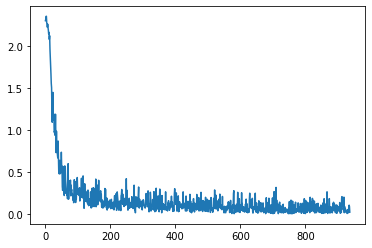

In [7]:
moduleNet = CNN().cuda()

intLR = 0.001
intMaxEpoch = 1
intBatchsize = 64

objOptim = torch.optim.Adam(moduleNet.parameters(), lr=intLR)

objTrainLoader = torch.utils.data.DataLoader(dataset=objTrainDataset, batch_size=intBatchsize, shuffle=True, num_workers=0)
objTestLoader = torch.utils.data.DataLoader(dataset=objTestDataset, batch_size=1, shuffle=False, num_workers=0)

intMaxStep = objTrainLoader.__len__()

lstLoss = []
for intCurrentEpoch in range(intMaxEpoch):
  moduleNet.train()
  for intBatchIdx, (tenImg, tenLabel) in enumerate(objTrainLoader):
    tenImg = tenImg.cuda()
    tenLabel = tenLabel.cuda()
    objOptim.zero_grad()
    tenOutput = moduleNet(tenImg)
    tenLoss = -torch.mean(torch.sum(tenLabel * torch.log(tenOutput), dim=1))
    tenLoss.backward()
    objOptim.step()

    lstLoss.append(tenLoss.item())
    if intBatchIdx % 100 == 0:
      print('{:<13s}{:<14s}{:<6s}{:<16s}{:<12s}{:<20.16f}'.format('Train Epoch: ', '[' + str(intCurrentEpoch) + '/' + str(intMaxEpoch) + ']', 'Step: ', '[' + str(intBatchIdx) + '/' + str(intMaxStep) + ']', 'train loss: ', tenLoss.item()))

  moduleNet.eval()
  intPos = 0
  intNeg = 0
  for intTestIdx, (tenTestImg, tenTestLabel) in enumerate(objTestLoader):
    tenTestImg = tenTestImg.cuda()
    tenTestLabel = tenTestLabel.cuda()
    tenTestOutput = moduleNet(tenTestImg)
    if torch.argmax(tenTestOutput) == torch.argmax(tenTestLabel):
      intPos += 1
    else:
      intNeg += 1
  fltAccuracy = intPos / (intPos+intNeg)
  print('Accuracy: ' + str(fltAccuracy * 100))

plt.plot(np.array(lstLoss))

tensor([[2.9720e-05, 7.1035e-05, 9.9845e-01, 4.5122e-04, 5.0993e-09, 9.9159e-09,
         4.2959e-08, 3.7538e-04, 6.1936e-04, 5.7109e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor(2, device='cuda:0')


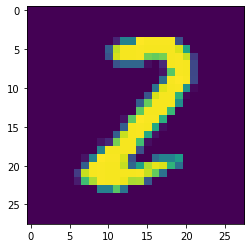

In [20]:
moduleToTensor = torchvision.transforms.ToTensor()

strImdir = './mnist/testing/2/1002.png'
pilImg = Image.open(strImdir)
tenImg = moduleToTensor(pilImg).cuda()

plt.imshow(tenImg.detach().squeeze().cpu().numpy())

tenPred = moduleNet(tenImg.unsqueeze(0))
print(tenPred)
print(torch.argmax(tenPred))

## Other Dataset
- CIFAR-10
- ImageNet

## Other CNN
- ResNet
- GoogleNet
- VGG-Net